In [1]:
import os
os.chdir("..")

import torch
import random
import utils
import data_utils
import json

import cbm
import plots
from conceptset_utils import most_similar_concepts

In [2]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/imagenet_lf_cbm"
device = "cuda"

with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device)
model = cbm.load_cbm(load_dir, device)

os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [3]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [4]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## 0. Record orignal model predictions for comparison

In [5]:
original_preds = utils.get_preds_cbm(model, val_data_t, device)

100%|██████████| 100/100 [05:29<00:00,  3.30s/it]


## 1. Explore incorrect predictions

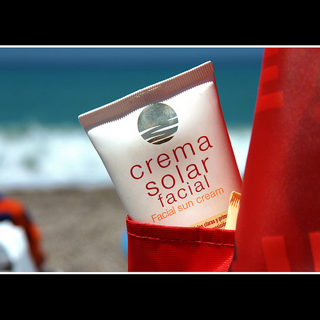

Img:41923, Gt:sunscreen, 1st Pred:lotion, Confidence:0.292
Top activations: a salty flavor:3.078, a note from Santa:2.727, a lotion or cream consistency:2.315, a slightly spicy taste:2.300, a rich flavor:2.272, 


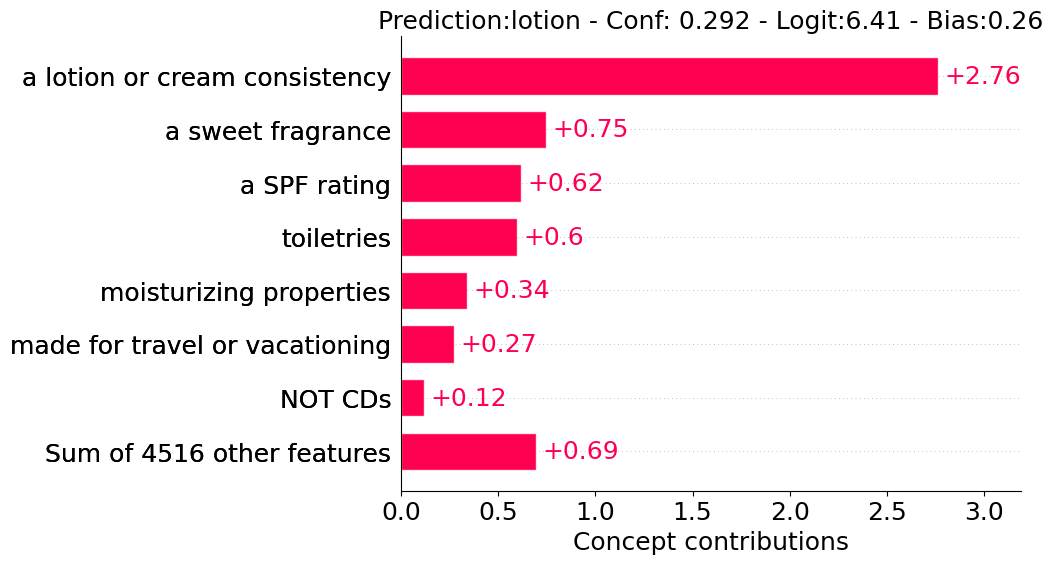

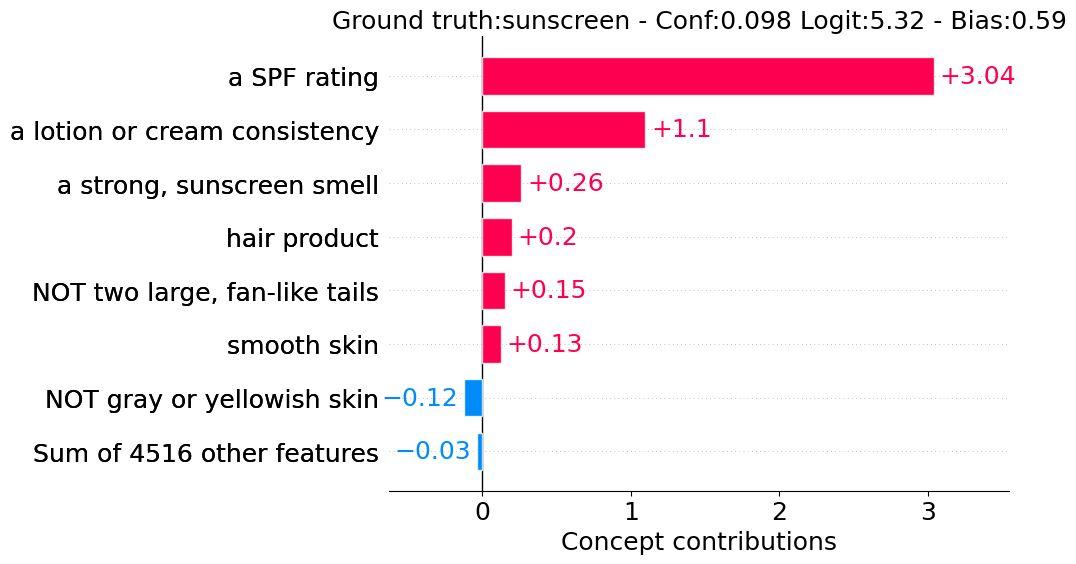

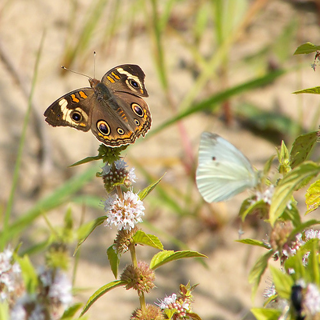

Img:16212, Gt:small white butterfly, 1st Pred:red admiral butterfly, Confidence:0.509
Top activations: a butterfly:5.086, a butterfly bush:5.010, wildflowers:4.175, lace-like patterns on wings:3.590, white stripes on the wings:3.576, 


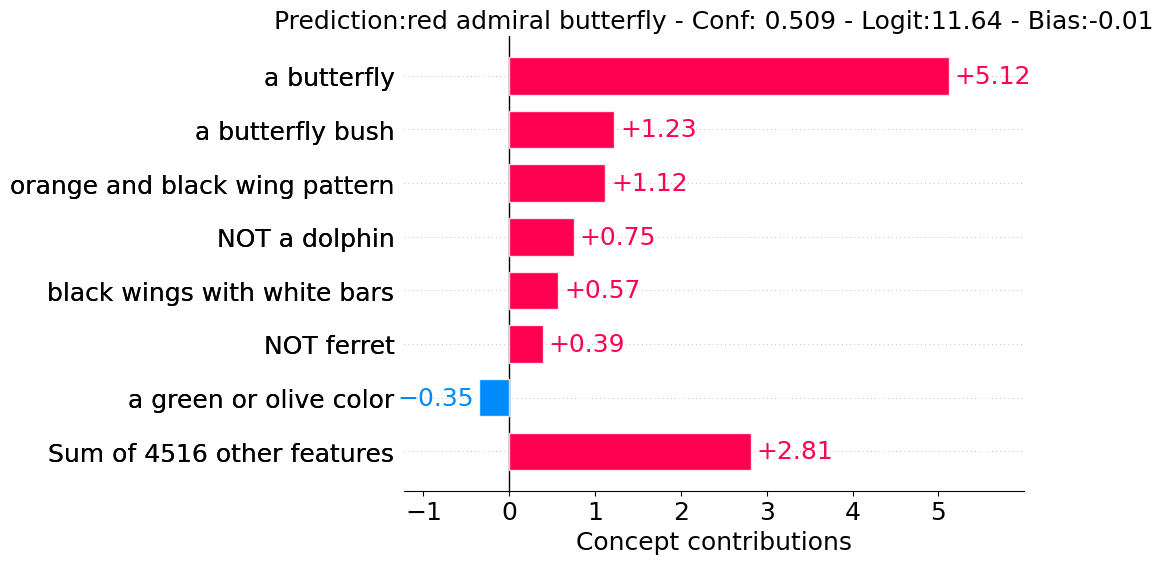

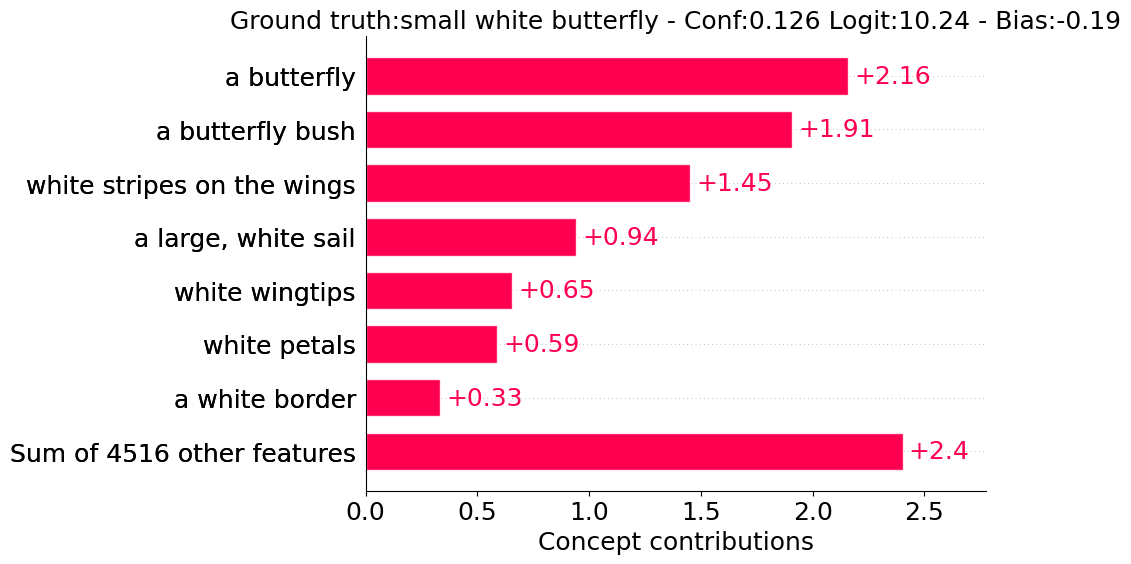

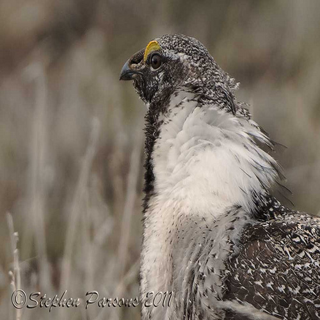

Img:4037, Gt:black grouse, 1st Pred:ptarmigan, Confidence:0.513
Top activations: a grouse:4.541, a bird of prey:4.323, a peahen:4.229, eagles:4.162, brown and white plumage:4.073, 


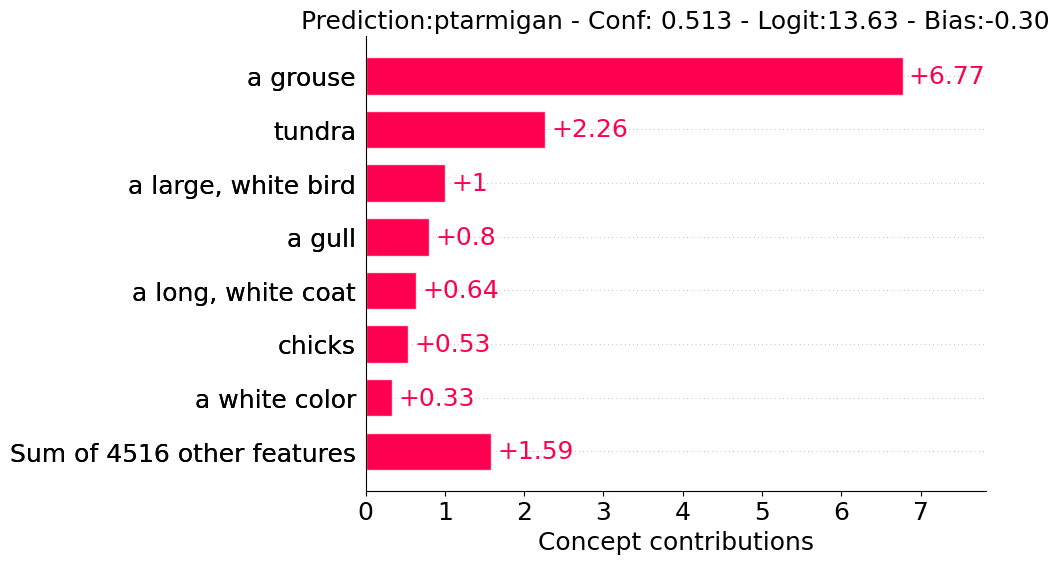

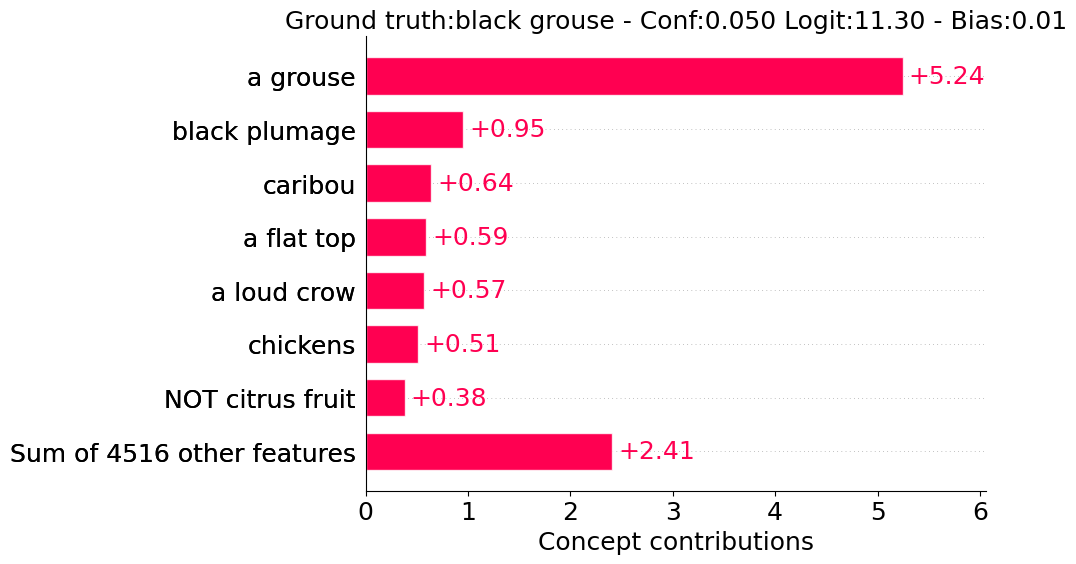

In [6]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=len(val_pil_data))
shown = 0
total = 3

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        
        outputs, concept_act = model(x)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        #print(outputs.shape, label)
        top_logit, top_class = torch.max(outputs[0], dim=0)
        
        if top_class == label:
            continue
        display(image.resize([320,320]))
        print("Img:{}, Gt:{}, 1st Pred:{}, Confidence:{:.3f}".format(i, classes[int(label)], classes[top_class], conf[top_class]))
        
        concept_vals, top_concepts = torch.topk(concept_act[0], k=5)
        to_print = "Top activations: "
        for i in range(len(concept_vals)):
            to_print += "{}:{:.3f}, ".format(concepts[int(top_concepts[i])], concept_vals[i])
        print(to_print)
        
        contributions = concept_act[0]*model.final.weight[top_class, :]
        feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
        values = contributions.cpu().numpy()
        max_display = min(int(sum(abs(values)>0.005))+1, 8)
        title = "Prediction:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_class], conf[top_class], top_logit, model.final.bias[top_class])
        plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=18)
        
        contributions = concept_act[0]*model.final.weight[label, :]
        values = contributions.cpu().numpy()
        max_display = min(int(sum(abs(values)>0.005))+1, 8)
        title = "Ground truth:{} - Conf:{:.3f} Logit:{:.2f} - Bias:{:.2f}".format(classes[label], conf[label], outputs[0, label], model.final.bias[label])
        plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=18)
        
        shown += 1
        if shown >= total:
            break

## 2. Select an input to focus on

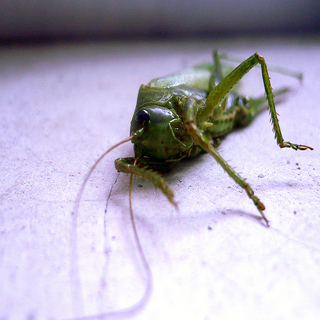

Img:15563, Gt:grasshopper, 1st Pred:cricket insect, Confidence:0.456
Top activations: a cricket player:4.210, a cricket wicket:4.181, a cricket umpire:3.990, an insect:3.837, a bug:3.775, 


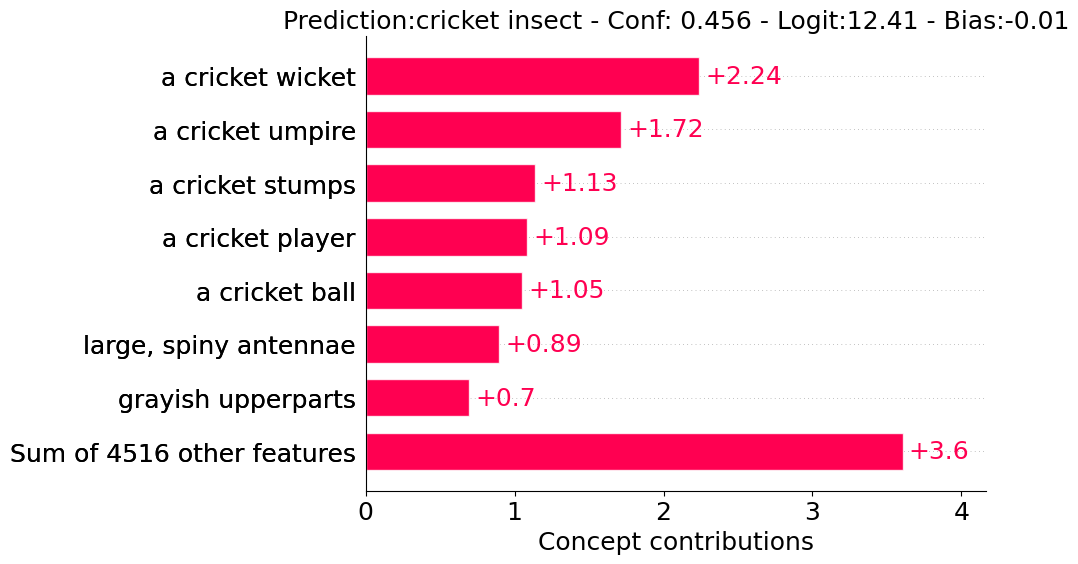

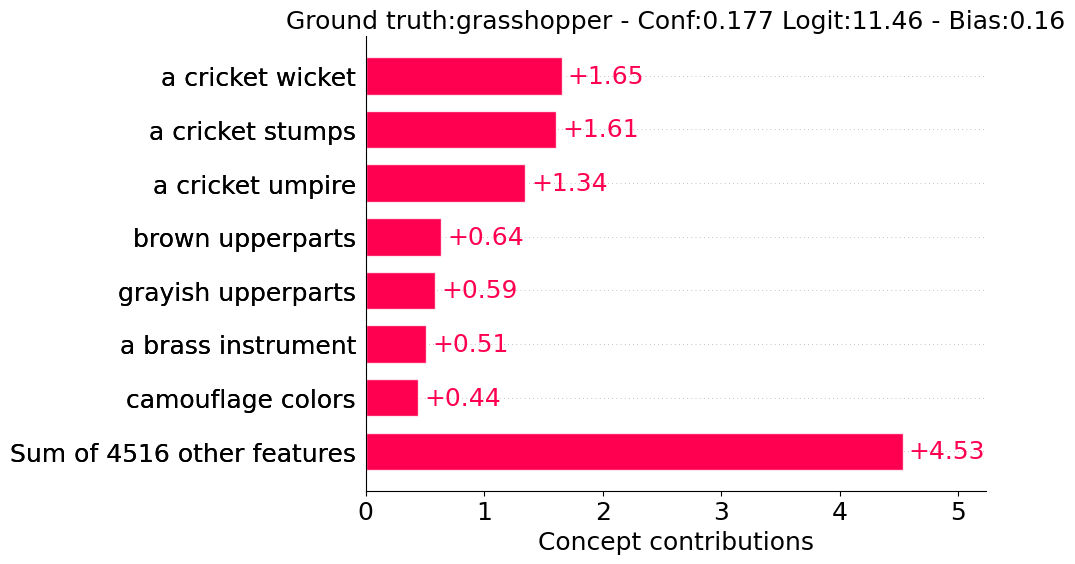

In [7]:
image_id = 15563
to_display = [image_id]

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        
        outputs, concept_act = model(x)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        top_logit, top_class = torch.max(outputs[0], dim=0)
        
        display(image.resize([320,320]))
        print("Img:{}, Gt:{}, 1st Pred:{}, Confidence:{:.3f}".format(i, classes[int(label)], classes[top_class], conf[top_class]))
        
        concept_vals, top_concepts = torch.topk(concept_act[0], k=5)
        to_print = "Top activations: "
        for i in range(len(concept_vals)):
            to_print += "{}:{:.3f}, ".format(concepts[int(top_concepts[i])], concept_vals[i])
        print(to_print)
        
        contributions = concept_act[0]*model.final.weight[top_class, :]
        feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
        values = contributions.cpu().numpy()
        max_display = min(int(sum(abs(values)>0.005))+1, 8)
        title = "Prediction:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_class], conf[top_class], top_logit, model.final.bias[top_class])
        plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=18)
        
        contributions = concept_act[0]*model.final.weight[label, :]
        values = contributions.cpu().numpy()
        max_display = min(int(sum(abs(values)>0.005))+1, 8)
        title = "Ground truth:{} - Conf:{:.3f} Logit:{:.2f} - Bias:{:.2f}".format(classes[label], conf[label], outputs[0, label], model.final.bias[label])
        plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=18)

## 3. Find concept to edit

We identify that a green color differentiates grasshoppers from crickets based on our domain knowledge, and is not reflected in the model.

In [8]:
#finds concepts in CBL most similar to the concept we want to edit
most_similar_concepts('green', concepts)

[('a green color', tensor(0.9064)),
 ('green or yellow-green color', tensor(0.8381)),
 ('a green or purple color', tensor(0.8100)),
 ('a red or green color', tensor(0.8002)),
 ('greenish-brown color', tensor(0.7979))]

In [9]:
concept_id = concepts.index('a green color')
#decide the margin, i.e. how much higher we want the correct class logit to be after edit
margin = 0.2
print(concept_id)

956


## 4. Calculate required weight change magnitude

In [10]:
x, gt_id = val_data_t[image_id]
x = x.unsqueeze(0).to(device)
outputs, concept_act = model(x)
pred_id = torch.argmax(outputs[0])

diff = outputs[0, pred_id] - outputs[0, gt_id] + margin

weight_change = (diff/concept_act[0, concept_id])/2
print(diff, weight_change)

tensor(1.1474, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1970, device='cuda:0', grad_fn=<DivBackward0>)


## 5 Perform the edit

In [11]:
edits = [{"class":"grasshopper", "concept":"a green color", "weight":weight_change},
             {"class":"cricket insect", "concept":"a green color", "weight":-weight_change}]

for dicti in edits:
    class_num = classes.index(dicti["class"])
    concept_num = concepts.index(dicti["concept"])
    old_w = model.final.weight[class_num, concept_num].clone()
    with torch.no_grad():
        model.final.weight[class_num, concept_num] += dicti["weight"]
    print("Weight: {} -> {}, changed {:.3f} -> {:.3f}".format(dicti["concept"], dicti["class"], old_w, model.final.weight[class_num, concept_num]))

Weight: a green color -> grasshopper, changed 0.000 -> 0.197
Weight: a green color -> cricket insect, changed 0.000 -> -0.197


## 6. Evaluate results

Corrected original input

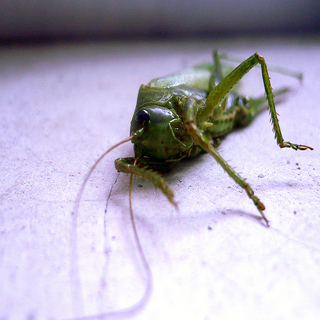

Img:15563, Gt:grasshopper, 1st Pred:grasshopper, Confidence:0.335
Top activations: a cricket player:4.210, a cricket wicket:4.181, a cricket umpire:3.990, an insect:3.837, a bug:3.775, 


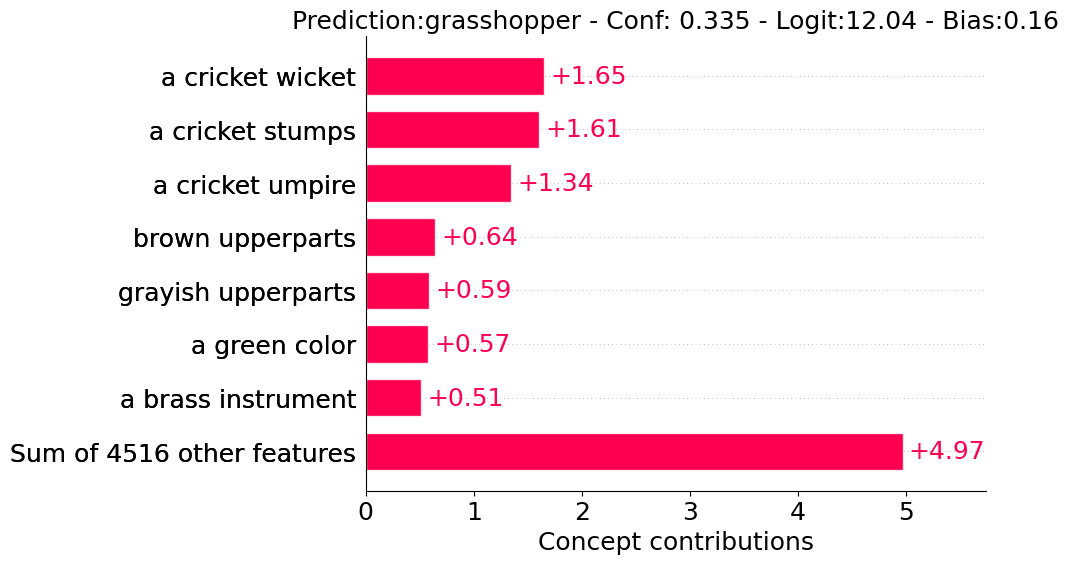

In [12]:
with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        
        outputs, concept_act = model(x)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        top_logit, top_class = torch.max(outputs[0], dim=0)
        
        display(image.resize([320,320]))
        print("Img:{}, Gt:{}, 1st Pred:{}, Confidence:{:.3f}".format(i, classes[int(label)], classes[top_class], conf[top_class]))
        
        concept_vals, top_concepts = torch.topk(concept_act[0], k=5)
        to_print = "Top activations: "
        for i in range(len(concept_vals)):
            to_print += "{}:{:.3f}, ".format(concepts[int(top_concepts[i])], concept_vals[i])
        print(to_print)
        
        contributions = concept_act[0]*model.final.weight[top_class, :]
        feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
        values = contributions.cpu().numpy()
        max_display = min(int(sum(abs(values)>0.005))+1, 8)
        title = "Prediction:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_class], conf[top_class], top_logit, model.final.bias[top_class])
        plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=18)

### Effect on other inputs

In [13]:
new_preds = utils.get_preds_cbm(model, val_data_t, device)

diff = (original_preds != new_preds)
changed_inds = diff.nonzero(as_tuple=True)[0]

original_correct = 0
new_correct = 0
for elem in changed_inds:
    gt = classes[val_pil_data.targets[elem]]
    orig_pred = classes[original_preds[elem]]
    new_pred = classes[new_preds[elem]]
    if gt==orig_pred:
        original_correct += 1
    elif gt==new_pred:
        new_correct += 1
    print("Img:{}, Gt:{},   Original:{},   New:{}".format(elem, gt, orig_pred, new_pred))
print("Total {} Corrected, {} turned wrong".format(new_correct, original_correct))

100%|██████████| 100/100 [05:29<00:00,  3.30s/it]

Img:6213, Gt:crayfish,   Original:cricket insect,   New:grasshopper
Img:15338, Gt:rhinoceros beetle,   Original:praying mantis,   New:grasshopper
Img:15550, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15552, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15563, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15565, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15568, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15570, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15572, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15573, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15574, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15577, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15583, Gt:grasshopper,   Original:cricket insect,   New:grasshopper
Img:15586, Gt:grasshopper,   Original:cricket insect,   New:gr

## Visualize some affected predictions

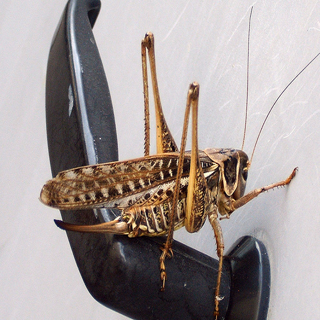

Img:15635, Gt:cricket insect, 1st Pred:cricket insect, Confidence:0.253
Top activations: chair:3.156, a basket:3.096, a marching band:3.073, a brass instrument:3.014, brown upperparts:2.978, 


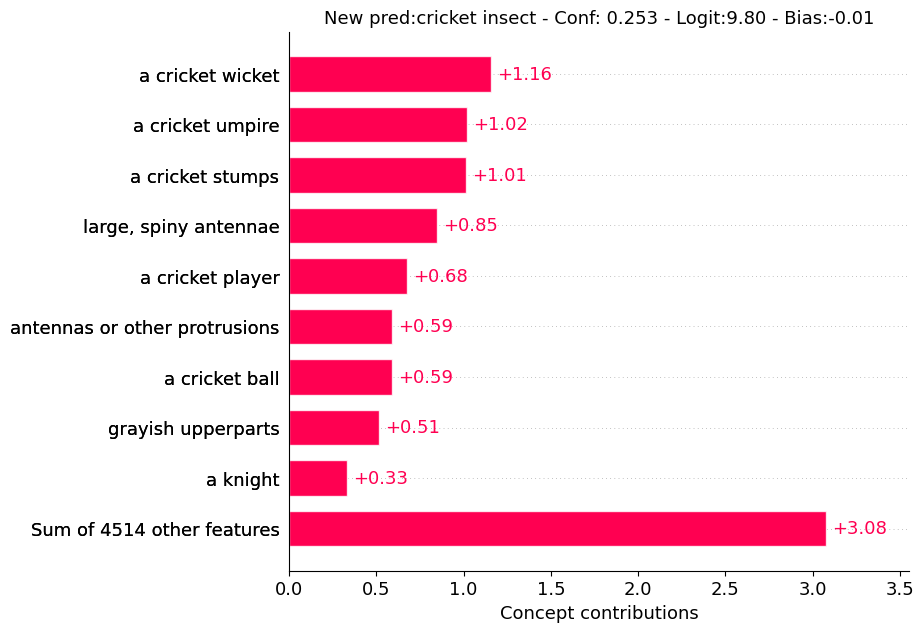

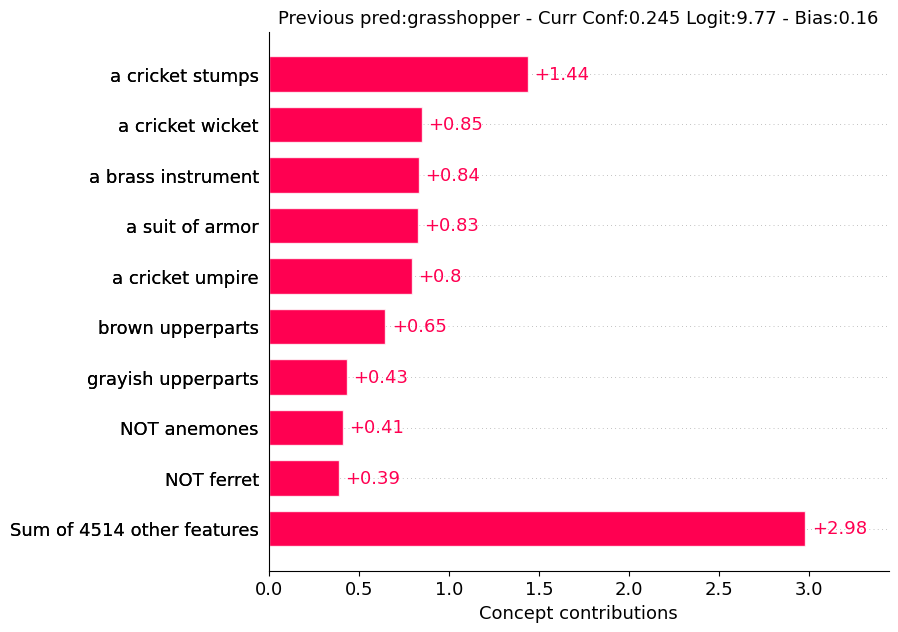

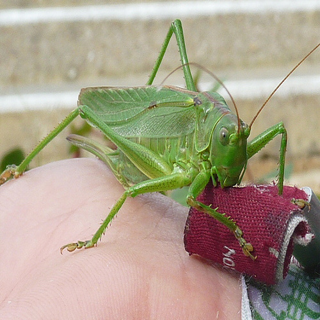

Img:15620, Gt:cricket insect, 1st Pred:grasshopper, Confidence:0.807
Top activations: a cricket player:5.152, a cricket wicket:4.911, a cricket umpire:4.556, a bug:4.555, an insect:4.537, 


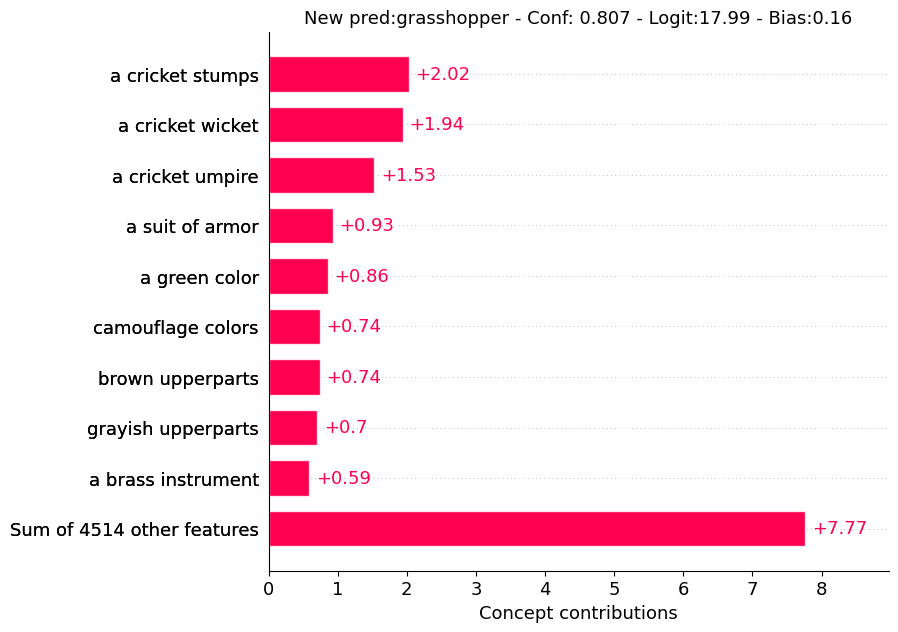

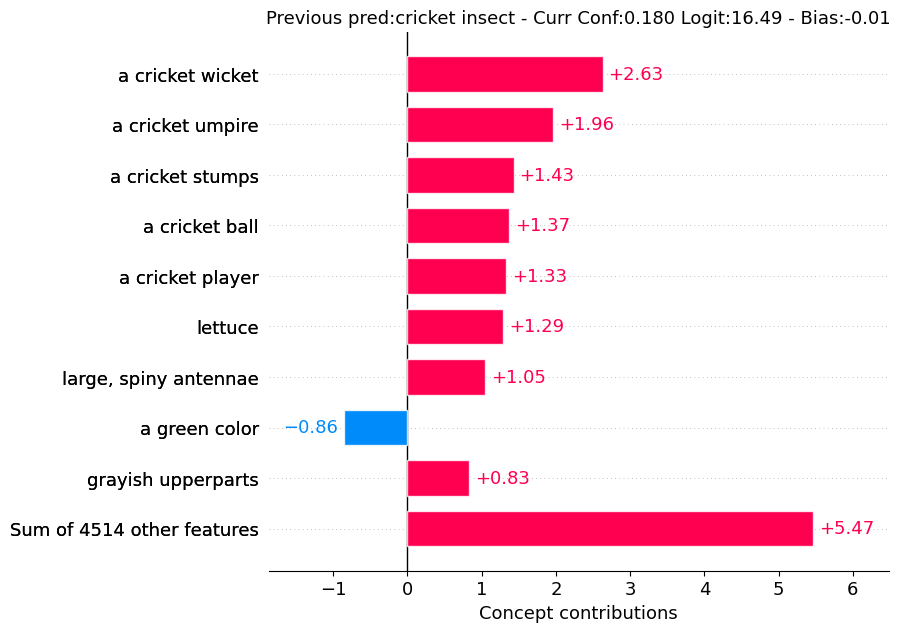

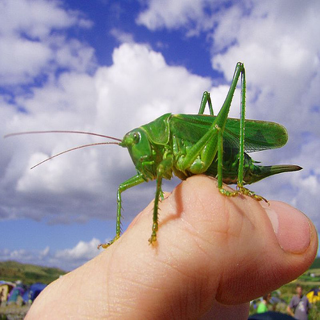

Img:15623, Gt:cricket insect, 1st Pred:grasshopper, Confidence:0.713
Top activations: a cricket player:4.330, a cricket umpire:4.120, a cricket wicket:4.075, a bug:3.681, an insect:3.617, 


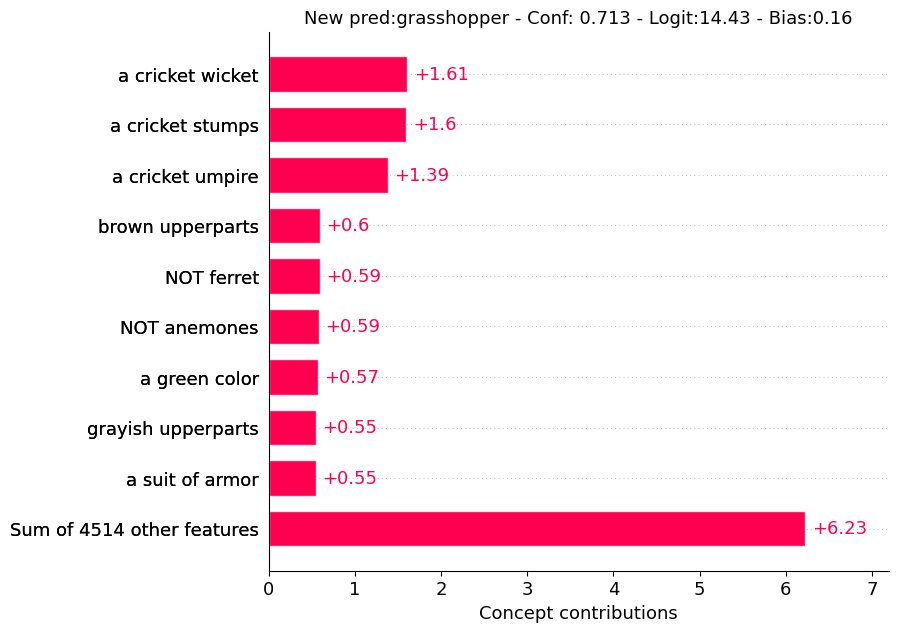

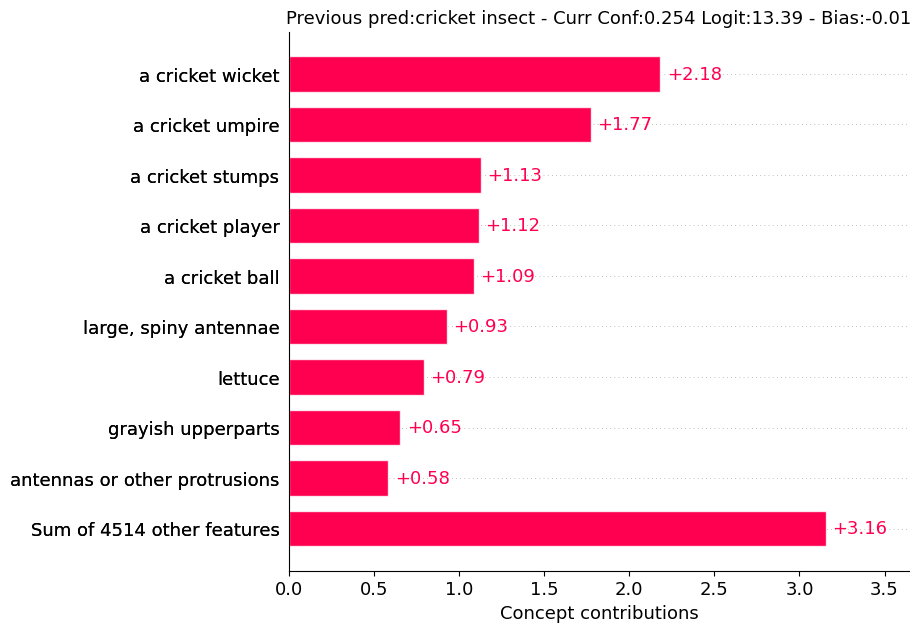

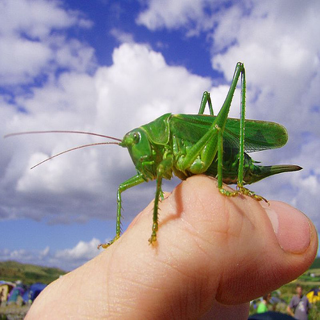

Img:15623, Gt:cricket insect, 1st Pred:grasshopper, Confidence:0.713
Top activations: a cricket player:4.330, a cricket umpire:4.120, a cricket wicket:4.075, a bug:3.681, an insect:3.617, 


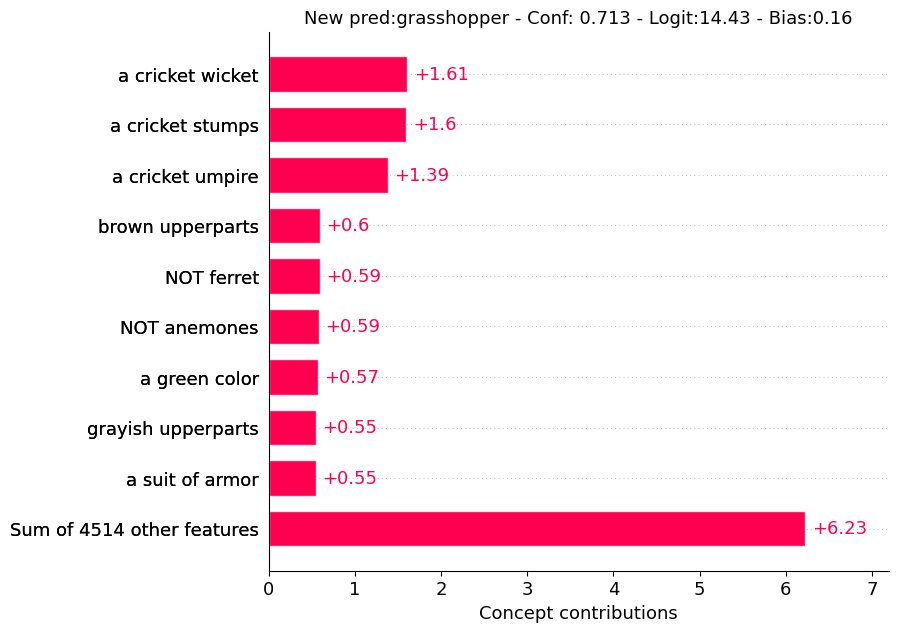

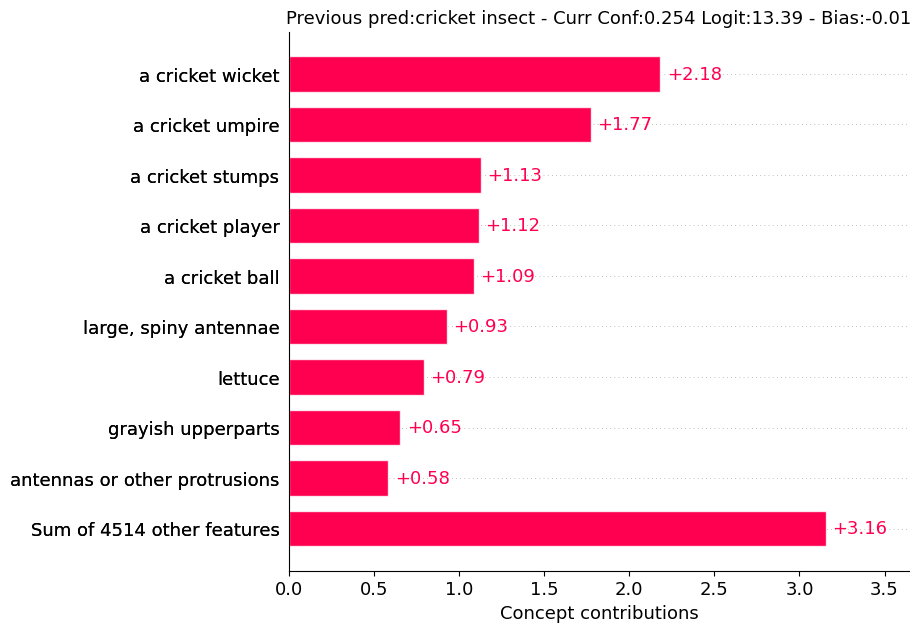

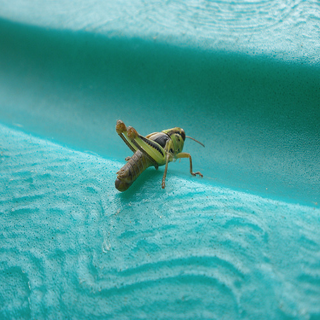

Img:15593, Gt:grasshopper, 1st Pred:grasshopper, Confidence:0.429
Top activations: a cricket wicket:3.887, a bug:3.632, a cricket player:3.434, arthropod:3.341, a green felt surface:3.314, 


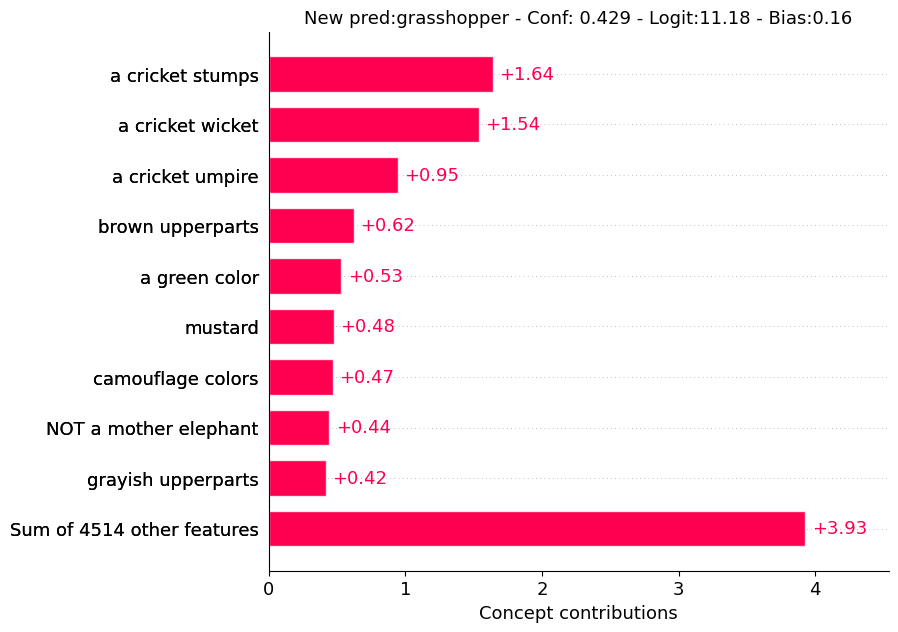

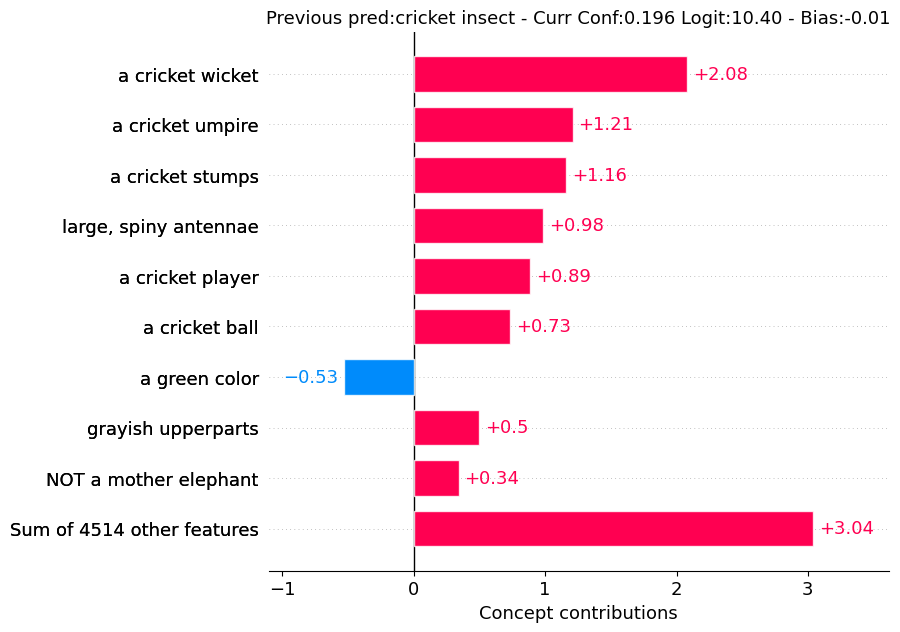

In [14]:
with torch.no_grad():
    for i in random.choices(changed_inds, k=5):
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        outputs, concept_act = model(x)
        
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        top_logit, top_class = torch.max(outputs[0], dim=0)
        display(image.resize([320,320]))
        print("Img:{}, Gt:{}, 1st Pred:{}, Confidence:{:.3f}".format(i, classes[int(label)], classes[top_class], conf[top_class]))
        
        concept_vals, top_concepts = torch.topk(concept_act[0], k=5)
        to_print = "Top activations: "
        for j in range(len(concept_vals)):
            to_print += "{}:{:.3f}, ".format(concepts[int(top_concepts[j])], concept_vals[j])
        print(to_print)
        
        contributions = concept_act[0]*model.final.weight[top_class, :]
        feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
        values = contributions.cpu().numpy()
        max_display = min(int(sum(abs(values)>0.005))+1, 10)
        title = "New pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_class], conf[top_class],
                                                                                 top_logit, model.final.bias[top_class])
        plots.bar(values, feature_names, max_display=max_display, title=title)
        
        old_pred = original_preds[i]
        contributions = concept_act[0]*model.final.weight[old_pred, :]
        values = contributions.cpu().numpy()
        max_display = min(int(sum(abs(values)>0.005))+1, 10)
        title = "Previous pred:{} - Curr Conf:{:.3f} Logit:{:.2f} - Bias:{:.2f}".format(classes[old_pred], conf[old_pred],
                                                                                        outputs[0, old_pred], model.final.bias[old_pred])
        plots.bar(values, feature_names, max_display=max_display, title=title)